In [2]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import kagglehub
from collections import defaultdict

In [3]:
path = kagglehub.dataset_download("mahmoudreda55/satellite-image-classification")
print("Path to dataset:", path)

100%|██████████| 21.8M/21.8M [00:01<00:00, 16.1MB/s]

Extracting files...


Path to dataset: C:\Users\jli20\.cache\kagglehub\datasets\mahmoudreda55\satellite-image-classification\versions\1


In [4]:
data_path = os.path.join(path, 'data')
subfolders = os.listdir(data_path)
print("Class folders:", subfolders)

Class folders: ['cloudy', 'desert', 'green_area', 'water']


In [5]:
img_size = (224, 224)
batch_size = 16

dataset = tf.keras.utils.image_dataset_from_directory(
    data_path,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

unbatched_ds = dataset.unbatch()

class_names = dataset.class_names
print("Class names:", class_names)

Found 5631 files belonging to 4 classes.
Class names: ['cloudy', 'desert', 'green_area', 'water']


In [6]:
"""
{
  'cloudy': [(img1, lbl1), (img2, lbl2)]
  'desert': [.......]
  ......
}
"""

class_datasets = defaultdict(list)

for image, label in unbatched_ds:
    class_idx = int(label.numpy())
    class_name = class_names[class_idx]
    class_datasets[class_name].append((image, label))

In [7]:
def make_class_dataset(data_tuples, batch_size):
    imgs, labels = zip(*data_tuples)
    ds = tf.data.Dataset.from_tensor_slices((list(imgs), list(labels)))
    return ds.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
cloudy_ds = make_class_dataset(class_datasets["cloudy"], batch_size)
desert_ds = make_class_dataset(class_datasets["desert"], batch_size)
green_ds  = make_class_dataset(class_datasets["green_area"], batch_size)
water_ds  = make_class_dataset(class_datasets["water"], batch_size)

In [9]:
def count_images(dataset):
    return sum(1 for _ in dataset.unbatch())

In [10]:
print("Cloudy images:", count_images(cloudy_ds))
print("Desert images:", count_images(desert_ds))
print("Green images:", count_images(green_ds))
print("Water images:", count_images(water_ds))

Cloudy images: 1500
Desert images: 1131
Green images: 1500
Water images: 1500


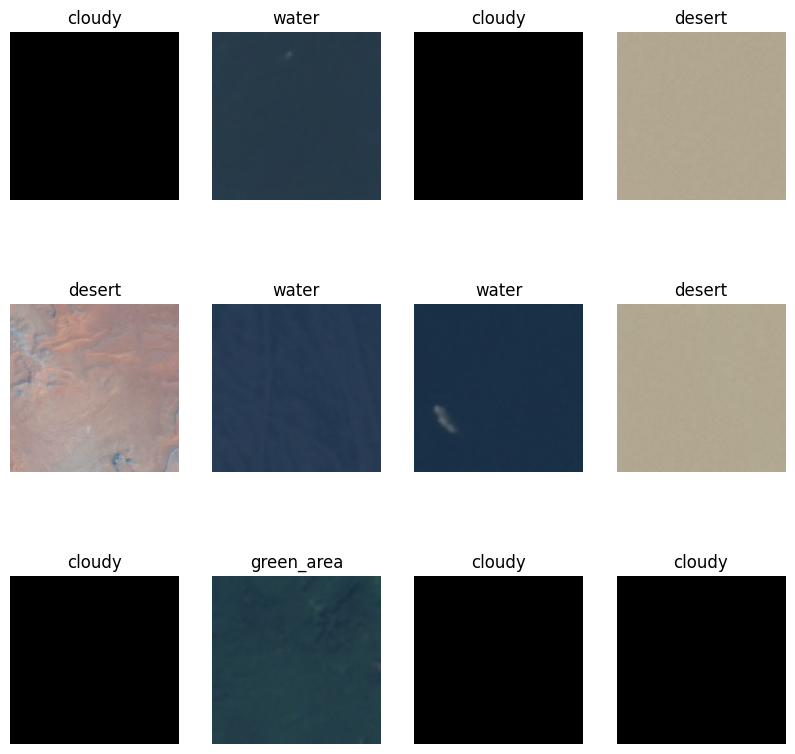

In [13]:
class_names = dataset.class_names

import matplotlib.pyplot as plt


number_of_images = 12

plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):  # One batch
    for i in range(number_of_images):
        ax = plt.subplot(number_of_images//4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
# train_ds = tf.keras.utils.image_dataset_from_directory(
#     data_path,
#     validation_split=0.2,      # 20% for validation
#     subset="training",
#     seed=42,
#     image_size=img_size,
#     batch_size=batch_size
# )

# val_ds = tf.keras.utils.image_dataset_from_directory(
#     data_path,
#     validation_split=0.2,
#     subset="validation",
#     seed=42,
#     image_size=img_size,
#     batch_size=batch_size
# )

# print("Train batches:", tf.data.experimental.cardinality(train_ds).numpy())
# print("Val batches:", tf.data.experimental.cardinality(val_ds).numpy())


In [ ]:
# from collections import Counter

# train_counter = Counter()

# for _, label in train_ds.unbatch():
#     train_counter[int(label.numpy())] += 1

# # Map class indices to names
# class_names = train_ds.class_names
# train_distribution = {class_names[i]: count for i, count in train_counter.items()}

# print("Training set class distribution:")
# for k, v in train_distribution.items():
#     print(f"{k}: {v}")

In [ ]:
shuffled_cloudy = (
    cloudy_ds
    .unbatch()
    .shuffle(buffer_size=2000)
    .batch(16)
    .prefetch(tf.data.AUTOTUNE)
)

shuffled_green = (
    green_ds
    .unbatch()
    .shuffle(buffer_size=2000)
    .batch(16)
    .prefetch(tf.data.AUTOTUNE)
)

shuffled_desert = (
    desert_ds
    .unbatch()
    .shuffle(buffer_size=2000)
    .batch(16)
    .prefetch(tf.data.AUTOTUNE)
)

shuffled_water = (
    water_ds
    .unbatch()
    .shuffle(buffer_size=2000)
    .batch(16)
    .prefetch(tf.data.AUTOTUNE)
)

In [19]:
print(type(water_ds))
print(type(shuffled_water))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


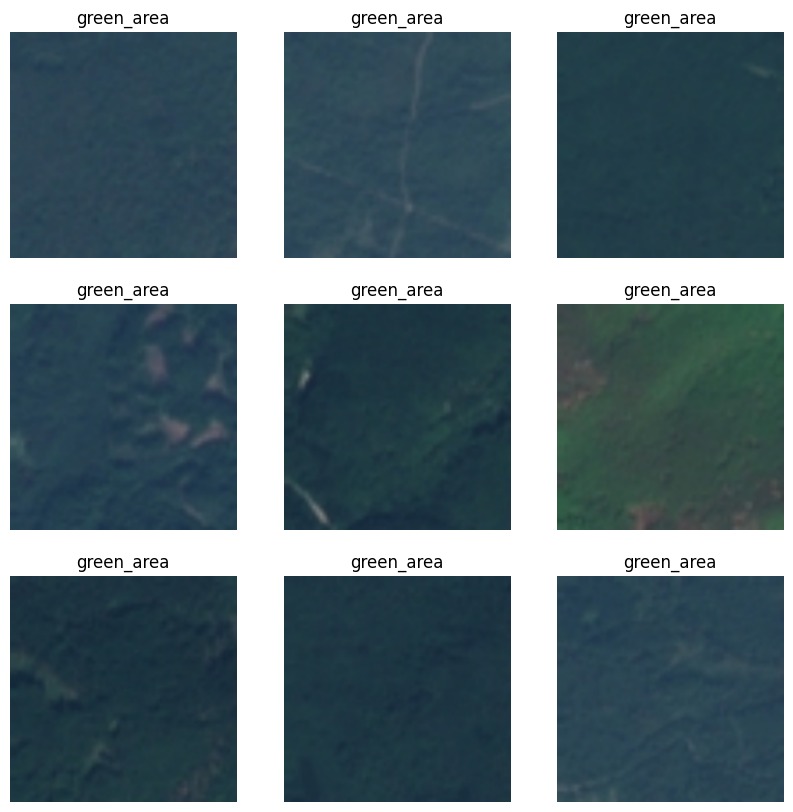

In [ ]:
number_of_images = 9

plt.figure(figsize=(10, 10))
for images, labels in shuffled_green.take(1):  # One batch
    for i in range(number_of_images):
        ax = plt.subplot(3,3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i].numpy())])
        plt.axis("off")

In [ ]:
number_of_images = 9

plt.figure(figsize=(10, 10))
for images, labels in shuffled_green.take(1):  # One batch
    for i in range(number_of_images):
        ax = plt.subplot(3,3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i].numpy())])
        plt.axis("off")

# works for pre shuffle datasets but not post shuffle datasets so something during the shuffle went wrong